In [1]:
# ==============================================================================
# Projeto de Análise Estatística Integrada da Relação entre Indicadores de Saúde Ambiental e o Consumo de Medicamentos no SUS (2024–2025)

# Elaborado por:
#João Paulo Motta Sampaio - SP3128172

#Jhonathan Ferroni Rodrigues da Silva - SP3158403

#Laryssa Giovanna Mendonça de Oliveira - SP3127435

#Renan Ladislau de Sousa - SP312651X

# Disciplina: Estatística e Probabilidade
# ==============================================================================

**Configurações**

In [ ]:
# ------------------------------------------------------------------------------
# 1. Configuração Inicial e Funções Auxiliares
# ------------------------------------------------------------------------------
# Este bloco importa as bibliotecas necessárias e define funções utilitárias
# para baixar e extrair arquivos ZIP do Google Drive, bem como para localizar
# arquivos CSV dentro das pastas extraídas.

In [2]:
import gdown
import zipfile
import os
import pandas as pd
import numpy as np # Importar numpy para np.nanmean
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, kruskal, ttest_ind # Adicionado ttest_ind aqui
from statsmodels.stats.proportion import proportions_ztest, proportion_confint


# Montar o Google Drive (opcional, mas útil se quiser salvar os Zips ou CSVs lá depois)
# Esta etapa permite que o Colab acesse arquivos no seu Google Drive, se necessário.
from google.colab import drive
drive.mount('/content/drive')

# Funções Auxiliares para Download e Extração
def download_and_extract_zip(file_id, zip_name, extract_folder):
    """
    Baixa um arquivo ZIP do Google Drive para o ambiente do Colab e o extrai.
    Args:
        file_id (str): ID do arquivo no Google Drive.
        zip_name (str): Nome para salvar o arquivo ZIP localmente.
        extract_folder (str): Pasta de destino para os arquivos extraídos.
    Returns:
        str: Caminho da pasta onde os arquivos foram extraídos.
    """
    zip_output_path = zip_name
    gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_output_path, quiet=True)

    if not os.path.exists(extract_folder):
        os.makedirs(extract_folder)

    with zipfile.ZipFile(zip_output_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    print(f"Arquivos de '{zip_name}' extraídos para: {extract_folder}")
    return extract_folder

def find_csv_file(extract_path):
    """
    Encontra o primeiro arquivo CSV dentro de uma estrutura de pastas extraída.
    Args:
        extract_path (str): Caminho da pasta raiz onde os arquivos foram extraídos.
    Returns:
        str: Caminho completo para o arquivo CSV encontrado.
    Raises:
        FileNotFoundError: Se nenhum arquivo CSV for encontrado na pasta.
    """
    for root, _, files in os.walk(extract_path):
        for file in files:
            if file.endswith('.csv'):
                return os.path.join(root, file)
    raise FileNotFoundError(f"Nenhum arquivo CSV encontrado em {extract_path}")

Mounted at /content/drive


**Carregamento e pré processamento**

In [3]:
# ------------------------------------------------------------------------------
# 2. Carregamento e Pré-processamento dos Dados
# ------------------------------------------------------------------------------
# Esta seção lida com o download, extração, carregamento e limpeza inicial
# dos dados de Estoque (BNAFAR) e Vigilância (SISAGUA).
# A leitura é limitada a 10.000 linhas por arquivo para otimização de memória
# no ambiente Google Colab gratuito.

# --- 2.1. Processamento de Dados de Estoque (BNAFAR) ---
# Baixa e consolida os dados de posição de estoque de medicamentos por mês.
# Realiza a limpeza de tipos de dados e padronização.
print("Iniciando processamento dos dados de Estoque (BNAFAR)...")

# Dicionário com IDs dos arquivos de estoque no Google Drive e seus respectivos meses
estoque_files = {
    '2024-05': "1pADpXRJ3Jrpd20wPkPEWH3hOb-50Zmev",
    '2024-06': "16pyx3dJWddXjfy6m8uhyV-1Geplh892j",
    '2024-07': "18cV88OTkBhojDC89GLeaF5jNid_vovWE",
    '2024-08': "1IzeXt6bCah6xLbgHlRNreACcEh_-T7fI",
    '2024-09': "10aVOLL849B2Z5IqTNvEwbp3VPr-00VYM",
    '2024-10': "14_yDrFQBMwSdh6fOLxhdieQUV2tfh8Ea",
    '2024-11': "10yGtanr1c9SzPnqRCwfMQyRTZUoyCBT9",
    '2024-12': "1jWVfFlNuetD6S-LlYZp6TCHBOJh0pfV6",
    '2025-01': "1cxqE9-4vAVCCg2whNv4qrN9SEFuIZxzn",
    '2025-02': "1tZOBBRAdmcKUe61U_YcQBgtzlcu64m4l",
    '2025-03': "1NypvxhPsRDI8DgCOFDgtvBpvxlAEg5iY",
    '2025-04': "1RIjA8Bwh0tx6i6VjUlrDlG_HnWAA6Rcz",
    '2025-05': "1mEbld4Dvx_AOaX9CA_wJc0FMEjsrD1bd"
}

# Definição dos tipos de dados para otimização de memória e tratamento de mixed types
estoque_dtypes = {
    'sg_uf': str, 'co_municipio_ibge': str, 'no_municipio': str, 'co_cnes': 'Int64',
    'no_razao_social': str, 'no_fantasia': str, 'co_cep': str, 'no_logradouro': str,
    'nu_endereco': str, 'no_bairro': str, 'nu_telefone': str, 'nu_latitude': str,
    'nu_longitude': str, 'no_email': str, 'dt_posicao_estoque': str, 'co_catmat': str,
    'ds_produto': str, 'qt_estoque': str, 'nu_lote': str, 'dt_validade': str,
    'tp_produto': str, 'sg_programa_saude': str, 'ds_programa_saude': str, 'sg_origem': str
}

dfs_estoque_processed = []

for ano_mes, file_id in estoque_files.items():
    zip_name = f"posicao_estoque_{ano_mes.replace('-', '')}.zip"
    extract_folder = f"/content/posicao_estoque_{ano_mes.replace('-', '')}"

    extracted_path = download_and_extract_zip(file_id, zip_name, extract_folder)
    csv_file = find_csv_file(extracted_path)

    try:
        df_temp = pd.read_csv(csv_file, encoding='latin1', sep=';', dtype=estoque_dtypes, nrows=10000, low_memory=False)
        df_temp['ano_mes'] = ano_mes # Adiciona a coluna ano_mes para análise temporal

        # Limpeza e conversão de tipos de dados para colunas específicas
        df_temp['qt_estoque'] = df_temp['qt_estoque'].astype(str).str.replace(',', '.', regex=False)
        df_temp['qt_estoque'] = pd.to_numeric(df_temp['qt_estoque'], errors='coerce').fillna(0) # Preenche NaNs com 0

        df_temp['nu_latitude'] = pd.to_numeric(df_temp['nu_latitude'], errors='coerce')
        df_temp['nu_longitude'] = pd.to_numeric(df_temp['nu_longitude'], errors='coerce')

        dfs_estoque_processed.append(df_temp)
        print(f"Carregado e processado: {csv_file} (Total de linhas: {len(df_temp)})")
    except Exception as e:
        print(f"Erro ao carregar ou processar {csv_file}: {e}")
        continue

# Concatenação de todos os DataFrames de estoque em um único DataFrame consolidado
estoque_consolidado = pd.concat(dfs_estoque_processed, ignore_index=True)
print("\n--- Estoque Consolidado Criado ---")
print(estoque_consolidado.info())
print("\nPrimeiras linhas do Estoque Consolidado:")
print(estoque_consolidado.head())

print("\nLimpeza e padronização de Estoque concluídas.")

# --- 2.2. Processamento de Dados de Vigilância (SISAGUA) ---
# Baixa e consolida os dados de vigilância de parâmetros básicos da água.
# Realiza a limpeza de tipos de dados, padronização e descarte de colunas vazias.
print("\nIniciando processamento dos dados de Vigilância (SISAGUA)...")

vigilancia_files = {
    '2024': "1PRtclfxtPNABf6mC6rkL8sCPlpIVL70s",
    '2025': "1m80EQIJft6Un_O_u8DH4xMP8OIrVg9SS"
}

# Definição dos tipos de dados para otimização de memória e tratamento de mixed types
vigilancia_dtypes = {
    'Região Geográfica': str, 'UF': str, 'Regional de Saúde': str, 'Município': str,
    'Código IBGE': str, 'Número da amostra': str, 'Motivo da coleta': str,
    'Tipo da Forma de Abastecimento': str, 'Código Forma de abastecimento': str,
    'Nome da Forma de Abastecimento': str, 'Nome da ETA/UTA': str,
    'Ano': 'Int64', 'Mês': 'Int64', 'Data da Coleta': str, 'Hora da coleta': str,
    'Data do Laudo': str, 'Data de Registro no SISAGUA': str,
    'Procedência da Coleta': str, 'Ponto de Coleta': str, 'Descrição do Local': str,
    'Zona': str, 'Categoria Área': str, 'Área': str, 'Tipo do local': str,
    'Local': str, 'Latitude': str, 'Longitude': str, 'Parâmetro': str,
    "'Análise realizada'": str, "'Data da análise'": str,
    "'LD'": str, "'LQ'": str, 'RESULTADO': str, "'Providência'": str
}

dfs_vigilancia_processed = []

for ano, file_id in vigilancia_files.items():
    zip_name = f"vigilancia_parametros_basicos_{ano}.zip"
    extract_folder = f"/content/vigilancia_dados_{ano}"

    extracted_path = download_and_extract_zip(file_id, zip_name, extract_folder)
    csv_file = find_csv_file(extracted_path)

    try:
        df_temp = pd.read_csv(csv_file, encoding='latin1', sep=';', dtype=vigilancia_dtypes, nrows=10000, low_memory=False)

        # Limpeza e conversão de tipos de dados para colunas específicas
        df_temp['RESULTADO'] = df_temp['RESULTADO'].astype(str).str.replace(',', '.', regex=False)
        df_temp['RESULTADO'] = pd.to_numeric(df_temp['RESULTADO'], errors='coerce')

        df_temp['Latitude'] = pd.to_numeric(df_temp['Latitude'], errors='coerce')
        df_temp['Longitude'] = pd.to_numeric(df_temp['Longitude'], errors='coerce')

        dfs_vigilancia_processed.append(df_temp)
        print(f"Carregado e processado: {csv_file} (Total de linhas: {len(df_temp)})")
    except Exception as e:
        print(f"Erro ao carregar ou processar {csv_file}: {e}")
        continue

# Concatenação de todos os DataFrames de vigilância em um único DataFrame consolidado
vigilancia_consolidado = pd.concat(dfs_vigilancia_processed, ignore_index=True)
print("\n--- Vigilância Consolidado Criado ---")
print(vigilancia_consolidado.info())
print("\nPrimeiras linhas do Vigilância Consolidado:")
print(vigilancia_consolidado.head())

# Limpeza e Padronização Final para Vigilância
# Renomeia a coluna do Código IBGE para padronização e descarta colunas sem dados
print("\nIniciando limpeza e padronização final dos dados de Vigilância...")
vigilancia_consolidado = vigilancia_consolidado.rename(columns={'Código IBGE': 'co_municipio_ibge'})
print(f"Tipo de dado de 'co_municipio_ibge' (vigilância): {vigilancia_consolidado['co_municipio_ibge'].dtype}")

# Identifica e descarta colunas que são completamente nulas ou com mais de 90% de nulos
cols_to_drop_vigilancia = []
if "'Análise realizada'" in vigilancia_consolidado.columns and vigilancia_consolidado["'Análise realizada'"].isnull().all():
    cols_to_drop_vigilancia.append("'Análise realizada'")
if "'Providência'" in vigilancia_consolidado.columns and vigilancia_consolidado["'Providência'"].isnull().all():
    cols_to_drop_vigilancia.append("'Providência'")
if "'LD'" in vigilancia_consolidado.columns and vigilancia_consolidado["'LD'"].isnull().all():
    cols_to_drop_vigilancia.append("'LD'")
if "'LQ'" in vigilancia_consolidado.columns and vigilancia_consolidado["'LQ'"].isnull().all():
    cols_to_drop_vigilancia.append("'LQ'")
if "Nome da ETA/UTA" in vigilancia_consolidado.columns and vigilancia_consolidado["Nome da ETA/UTA"].isnull().sum() > (len(vigilancia_consolidado) * 0.9):
    cols_to_drop_vigilancia.append("Nome da ETA/UTA")

if cols_to_drop_vigilancia:
    vigilancia_consolidado = vigilancia_consolidado.drop(columns=cols_to_drop_vigilancia)
    print(f"Colunas descartadas de Vigilância: {cols_to_drop_vigilancia}")
else:
    print("Nenhuma coluna totalmente nula ou com mais de 90% de nulos para descartar em Vigilância.")

print("\nLimpeza e padronização de Vigilância concluídas.")

# --- 2.3. Junção (Merge) dos DataFrames ---
# Realiza o merge entre os dados de estoque e vigilância com base no código IBGE do município.
print("\nIniciando o JOIN (merge) dos DataFrames...")

estoque_municipios = set(estoque_consolidado['co_municipio_ibge'].unique())
vigilancia_municipios = set(vigilancia_consolidado['co_municipio_ibge'].unique())

municipios_em_comum = estoque_municipios.intersection(vigilancia_municipios)
print(f"Número de municípios em comum antes do merge: {len(municipios_em_comum)}")

if not municipios_em_comum:
    print("AVISO: Não há municípios em comum entre os datasets de estoque e vigilância com os dados limitados (10k linhas).")
    print("O df_analise resultante do inner join será vazio ou terá poucas linhas.")

df_analise = pd.merge(estoque_consolidado, vigilancia_consolidado, on='co_municipio_ibge', how='inner')

print("\n--- DataFrame Final para Análise (df_analise) Criado ---")
print(df_analise.info())
print("\nPrimeiras linhas do df_analise:")
print(df_analise.head())

print(f"\nNúmero de municípios únicos no df_analise: {df_analise['co_municipio_ibge'].nunique()}")
print(f"Número de não-nulos em 'ano_mes' (estoque) no df_analise: {df_analise['ano_mes'].notna().sum()} de {len(df_analise)}")

print("\nProcesso concluído! Você agora tem um DataFrame consolidado com os dados limitados para o seu projeto.")

Iniciando processamento dos dados de Estoque (BNAFAR)...
Arquivos de 'posicao_estoque_202405.zip' extraídos para: /content/posicao_estoque_202405
Carregado e processado: /content/posicao_estoque_202405/Posicao_Estoque_21-05-2024.csv (Total de linhas: 10000)
Arquivos de 'posicao_estoque_202406.zip' extraídos para: /content/posicao_estoque_202406
Carregado e processado: /content/posicao_estoque_202406/Posicao_Estoque_21-06-2024.csv (Total de linhas: 10000)
Arquivos de 'posicao_estoque_202407.zip' extraídos para: /content/posicao_estoque_202407
Carregado e processado: /content/posicao_estoque_202407/Posicao_Estoque_21-07-2024.csv (Total de linhas: 10000)
Arquivos de 'posicao_estoque_202408.zip' extraídos para: /content/posicao_estoque_202408
Carregado e processado: /content/posicao_estoque_202408/Posicao_Estoque_22-08-2024.csv (Total de linhas: 10000)
Arquivos de 'posicao_estoque_202409.zip' extraídos para: /content/posicao_estoque_202409
Carregado e processado: /content/posicao_estoque_2

**Preparação de Variáveis para Análise Estatística**

In [4]:
# ------------------------------------------------------------------------------
# 3. Preparação de Variáveis para Análise Estatística
# ------------------------------------------------------------------------------
# Este bloco cria novas variáveis categóricas essenciais para as análises
# descritivas e inferenciais, como a classificação da qualidade da água
# e a categorização de medicamentos (antibióticos, antiparasitários).

print("\nIniciando preparação de variáveis para análise estatística...")

# --- 3.1. Classificação da Qualidade da Água ---
# Define a função para classificar a qualidade da água como 'Adequada',
# 'Inadequada' ou 'Não Classificado' com base em limites de potabilidade.
def classificar_agua(row):
    parametro = row['Parâmetro']
    resultado = row['RESULTADO']

    if parametro == 'Cloro residual livre (mg/L)':
        if pd.notna(resultado) and 0.2 <= resultado <= 5.0:
            return 'Adequada'
        else:
            return 'Inadequada'
    elif parametro == 'pH':
        if pd.notna(resultado) and 6.0 <= resultado <= 9.5:
            return 'Adequada'
        else:
            return 'Inadequada'
    elif parametro == 'Turbidez (uT)':
        if pd.notna(resultado) and resultado < 5.0:
            return 'Adequada'
        else:
            return 'Inadequada'
    return 'Não Classificado' # Para outros parâmetros ou se o parâmetro for NaN

df_analise['qualidade_agua_simples'] = df_analise.apply(classificar_agua, axis=1)
print("Coluna 'qualidade_agua_simples' criada e aplicada.")


Iniciando preparação de variáveis para análise estatística...
Coluna 'qualidade_agua_simples' criada e aplicada.


**Classificação de Medicamentos**

In [5]:
# --- 3.2. Classificação de Medicamentos ---
# Define funções para identificar antibióticos e antiparasitários
# com base em palavras-chave no nome do produto, e cria uma categoria geral.
palavras_chave_antibioticos = [
    'amoxicilina', 'azitromicina', 'cefalexina', 'ciprofloxacino', 'metronidazol',
    'sulfametoxazol', 'cotrimoxazol', 'penicilina', 'doxiciclina', 'nitrofurantoina',
    'claritromicina', 'ampicilina', 'clindamicina', 'lincomicina', 'eritromicina',
    'piperacilina', 'tazobactam', 'oxacilina', 'aztreonam', 'meropenem', 'imipenem',
    'gentamicina', 'amikacina', 'tetraciclina', 'cloranfenicol'
]

palavras_chave_antiparasitarios = [
    'albendazol', 'mebendazol', 'ivermectina', 'permetrina', 'nitazoxanida',
    'secnidazol', 'tinidazol', 'benzoato de benzila', 'praziquantel', 'pirantel'
]

def is_antibiotic(ds_produto):
    if isinstance(ds_produto, str):
        return any(keyword in ds_produto.lower() for keyword in palavras_chave_antibioticos)
    return False

def is_antiparasitic(ds_produto):
    if isinstance(ds_produto, str):
        return any(keyword in ds_produto.lower() for keyword in palavras_chave_antiparasitarios)
    return False

df_analise['is_antibiotico'] = df_analise['ds_produto'].apply(is_antibiotic)
df_analise['is_antiparasitario'] = df_analise['ds_produto'].apply(is_antiparasitic)

def classificar_medicamento(row):
    if row['is_antibiotico']:
        return 'Antibiótico'
    if row['is_antiparasitario']:
        return 'Antiparasitário'
    return 'Outros'

df_analise['Categoria_Medicamento'] = df_analise.apply(classificar_medicamento, axis=1)
print("Colunas de classificação de medicamentos criadas.")

Colunas de classificação de medicamentos criadas.


**Estatistica Descritiva**

In [6]:
# ------------------------------------------------------------------------------
# 4. Estatística Descritiva
# ------------------------------------------------------------------------------
# Esta seção realiza análises para resumir e visualizar os dados,
# incluindo médias agrupadas, distribuições e gráficos.

print("\nIniciando análises de Estatística Descritiva...")

# --- 4.1. Médias Agrupadas ---
# Calcula a média da quantidade em estoque por qualidade da água.
print("\n--- Média de 'qt_estoque' por qualidade de água ---")
print(df_analise.groupby('qualidade_agua_simples')['qt_estoque'].mean())

# --- 4.2. Investigação de Estoque de Antibióticos e Antiparasitários ---
# Filtra e calcula o estoque total e por tipo de medicamento para municípios com água inadequada.
df_inadequada = df_analise[df_analise['qualidade_agua_simples'] == 'Inadequada'].copy()

estoque_total_antibioticos_inadequada = df_inadequada[df_inadequada['is_antibiotico']]['qt_estoque'].sum()
estoque_total_antiparasitarios_inadequada = df_inadequada[df_inadequada['is_antiparasitario']]['qt_estoque'].sum()
estoque_total_geral_inadequada = df_inadequada['qt_estoque'].sum()

print(f"\nEstoque total de antibióticos em municípios com água Inadequada: {estoque_total_antibioticos_inadequada:,.2f}")
print(f"Estoque total de antiparasitários em municípios com água Inadequada: {estoque_total_antiparasitarios_inadequada:,.2f}")
print(f"Estoque total geral de todos os medicamentos em municípios com água Inadequada: {estoque_total_geral_inadequada:,.2f}")

print("\nTop 10 antibióticos em estoque em municípios com água Inadequada:")
print(df_inadequada[df_inadequada['is_antibiotico']].groupby('ds_produto')['qt_estoque'].sum().nlargest(10))

print("\nTop 10 antiparasitários em estoque em municípios com água Inadequada:")
print(df_inadequada[df_inadequada['is_antiparasitario']].groupby('ds_produto')['qt_estoque'].sum().nlargest(10))

# --- 4.3. Distribuição dos Municípios por Qualidade da Água ---
# Identifica quais dos 7 municípios únicos contribuem para cada categoria de qualidade da água.
municipios_ibge = ['110001', '110002', '230500', '230510', '230523', '230526', '353650']
municipio_mapping = df_analise[['co_municipio_ibge', 'no_municipio']].drop_duplicates().set_index('co_municipio_ibge')['no_municipio'].to_dict()
municipios_por_qualidade = df_analise.groupby('qualidade_agua_simples')['co_municipio_ibge'].unique()

print("\n--- Distribuição dos 7 municípios únicos por categoria de qualidade da água ---")
for qualidade, ibge_list in municipios_por_qualidade.items():
    nomes_municipios = [municipio_mapping.get(ibge, ibge) for ibge in ibge_list if ibge in municipios_ibge]
    if nomes_municipios:
        print(f"  {qualidade}: {', '.join(sorted(nomes_municipios))}")
    else:
        print(f"  {qualidade}: Nenhum dos 7 municípios únicos contribui para esta categoria.")


Iniciando análises de Estatística Descritiva...

--- Média de 'qt_estoque' por qualidade de água ---
qualidade_agua_simples
Adequada            2879.464185
Inadequada          4237.004028
Não Classificado    6046.202487
Name: qt_estoque, dtype: float64

Estoque total de antibióticos em municípios com água Inadequada: 58,271,697.00
Estoque total de antiparasitários em municípios com água Inadequada: 12,947,862.00
Estoque total geral de todos os medicamentos em municípios com água Inadequada: 637,431,834.00

Top 10 antibióticos em estoque em municípios com água Inadequada:
ds_produto
AZITROMICINA 500 MG COMPRIMIDO ELENCO ESTADUAL                           32444838.0
CEFALEXINA 500 MG  COMPRIMIDO                                            12551916.0
CIPROFLOXACINO, CLORIDRATO 500 MG  COMPRIMIDO ELENCO ESTADUAL             7505745.0
AMOXICILINA 500 MG CÁPSULA                                                1596207.0
METRONIDAZOL 250 MG COMPRIMIDO                                            

**Gráficos Descritivos**

In [ ]:
# --- 4.4. Gráficos Descritivos ---
# Gera boxplots, gráficos de barras e um mapa de pontos para visualizar as distribuições e relações.

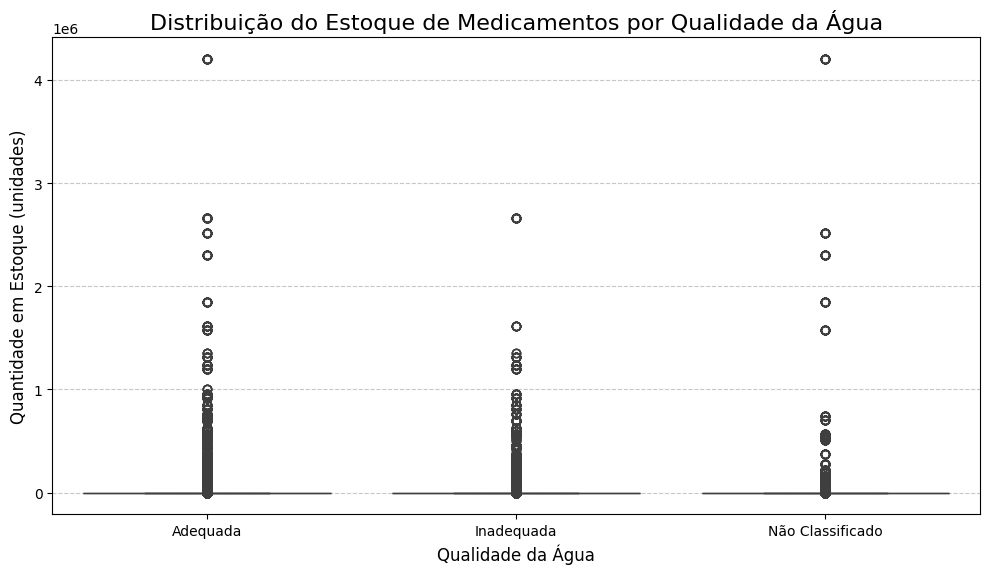

In [7]:
# Boxplot do Estoque Total vs. Qualidade da Água
plt.figure(figsize=(10, 6))
sns.boxplot(x='qualidade_agua_simples', y='qt_estoque', data=df_analise)
plt.title('Distribuição do Estoque de Medicamentos por Qualidade da Água', fontsize=16)
plt.xlabel('Qualidade da Água', fontsize=12)
plt.ylabel('Quantidade em Estoque (unidades)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<Figure size 1200x700 with 0 Axes>

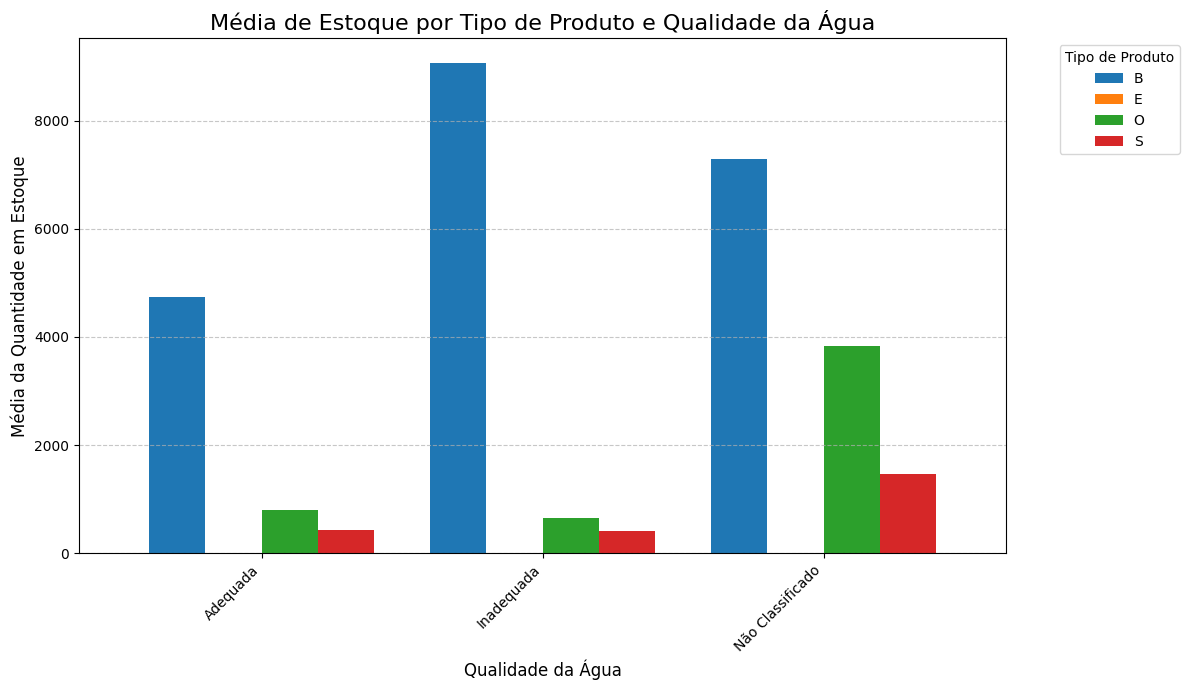

In [8]:
# Gráfico de Barras: Média de Estoque por Tipo de Produto e Qualidade da Água
plt.figure(figsize=(12, 7))
estoque_por_tipo_qualidade = df_analise.groupby(['qualidade_agua_simples', 'tp_produto'])['qt_estoque'].mean().unstack(fill_value=0)
estoque_por_tipo_qualidade.plot(kind='bar', figsize=(12, 7), width=0.8)
plt.title('Média de Estoque por Tipo de Produto e Qualidade da Água', fontsize=16)
plt.xlabel('Qualidade da Água', fontsize=12)
plt.ylabel('Média da Quantidade em Estoque', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Tipo de Produto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<Figure size 1200x700 with 0 Axes>

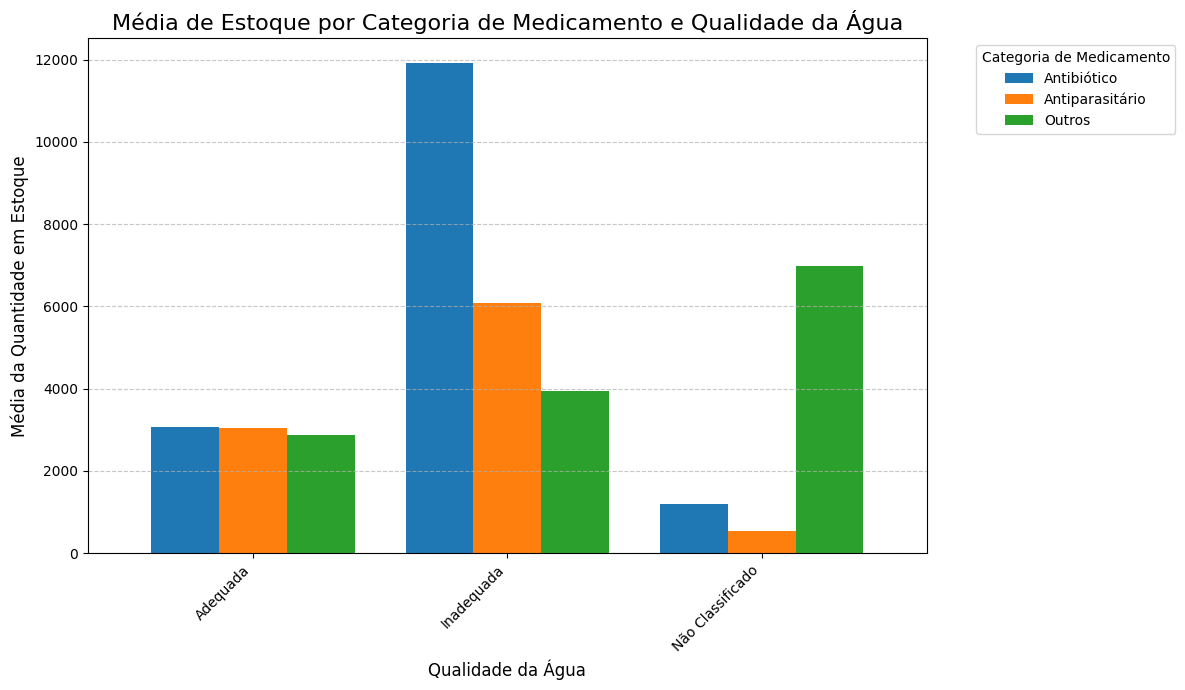

In [9]:
# Gráfico de Barras: Média de Estoque por Categoria de Medicamento e Qualidade da Água
plt.figure(figsize=(12, 7))
estoque_por_med_qualidade = df_analise.groupby(['qualidade_agua_simples', 'Categoria_Medicamento'])['qt_estoque'].mean().unstack(fill_value=0)
estoque_por_med_qualidade.plot(kind='bar', figsize=(12, 7), width=0.8)
plt.title('Média de Estoque por Categoria de Medicamento e Qualidade da Água', fontsize=16)
plt.xlabel('Qualidade da Água', fontsize=12)
plt.ylabel('Média da Quantidade em Estoque', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Categoria de Medicamento', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [10]:
# Mapa de Pontos: Qualidade da Água e Estoque de Medicamentos por Município
# Requer geopandas e plotly, instalados no início do notebook
import geopandas as gpd
import plotly.express as px

df_municipio_mapa_pontos = df_analise.groupby('co_municipio_ibge').agg(
    estoque_total=('qt_estoque', 'sum'),
    qualidade_predominante=('qualidade_agua_simples', lambda x: x.mode()[0] if not x.mode().empty else 'Não Definido'),
    nome_municipio=('no_municipio', 'first'),
    lat_central=('nu_latitude', lambda x: np.nanmean(x) if pd.notna(x).any() else None),
    lon_central=('nu_longitude', lambda x: np.nanmean(x) if pd.notna(x).any() else None)
).reset_index()

municipios_analisados_ibge = ['110001', '110002', '230500', '230510', '230523', '230526', '353650']
df_municipio_mapa_pontos = df_municipio_mapa_pontos[df_municipio_mapa_pontos['co_municipio_ibge'].isin(municipios_analisados_ibge)]
df_municipio_mapa_pontos.dropna(subset=['lat_central', 'lon_central'], inplace=True)

print("\n--- Dados agregados por município para o mapa de pontos ---")
print(df_municipio_mapa_pontos)

if not df_municipio_mapa_pontos.empty:
    color_map_points = {
        'Adequada': 'green', 'Inadequada': 'red', 'Não Classificado': 'grey', 'Não Definido': 'darkgrey'
    }
    fig = px.scatter_mapbox(df_municipio_mapa_pontos,
                            lat="lat_central", lon="lon_central",
                            color="qualidade_predominante", size="estoque_total",
                            hover_name="nome_municipio", hover_data={"estoque_total": ":,.0f", "qualidade_predominante": True},
                            color_discrete_map=color_map_points,
                            zoom=3, height=600,
                            title='Qualidade da Água e Estoque de Medicamentos por Município'
                           )
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
    fig.show()
else:
    print("\nNão foi possível gerar o mapa de pontos porque não há dados de lat/lon válidos para os 7 municípios selecionados.")



--- Dados agregados por município para o mapa de pontos ---
  co_municipio_ibge  estoque_total qualidade_predominante  \
0            110001   3.821063e+08               Adequada   
1            110002   1.699818e+09               Adequada   
6            353650   5.188200e+04       Não Classificado   

          nome_municipio  lat_central  lon_central  
0  ALTA FLORESTA D'OESTE   -11.944930   -61.996130  
1              ARIQUEMES    -9.904625   -63.041354  
6               Paulínia   -22.784708   -47.159007  


**Distribuições**

Limiar para 'alto estoque' (percentil 75): 55.00 unidades

--- Frequência de registros com 'alto estoque' por Categoria de Medicamento ---
Categoria_Medicamento
Outros             208431
Antibiótico         15840
Antiparasitário      5091
Name: count, dtype: int64


/tmp/ipython-input-11-4072205218.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




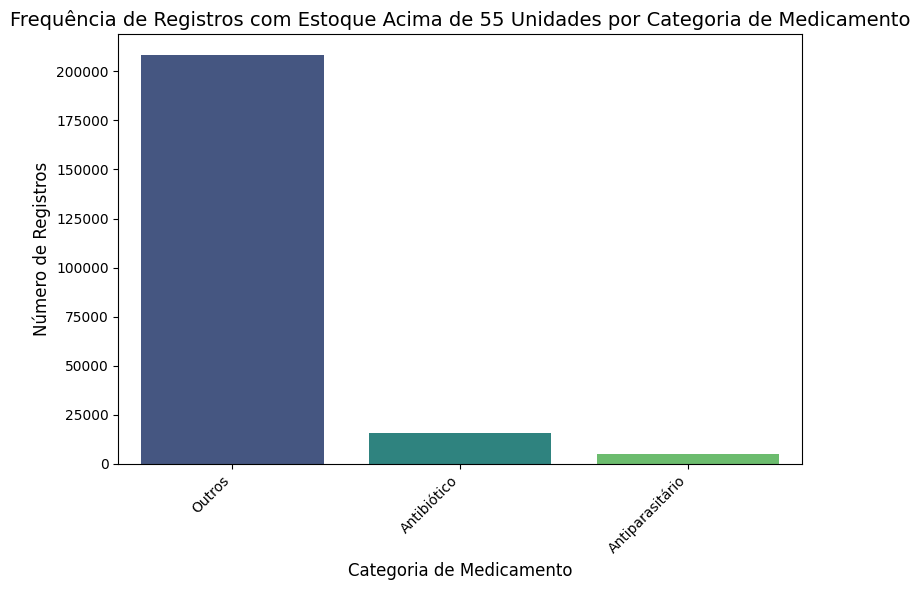


--- Média de Estoque por Mês da Coleta da Água (Sazonalidade - Vigilância) ---
Mês
1     3594.152087
2     2722.761493
3     3488.465249
4     2255.446018
5     6368.900670
6     5225.256033
7     6030.540174
8     5225.256033
9     7197.653231
10    4187.103012
11    7197.653231
12     838.934945
Name: qt_estoque, dtype: float64


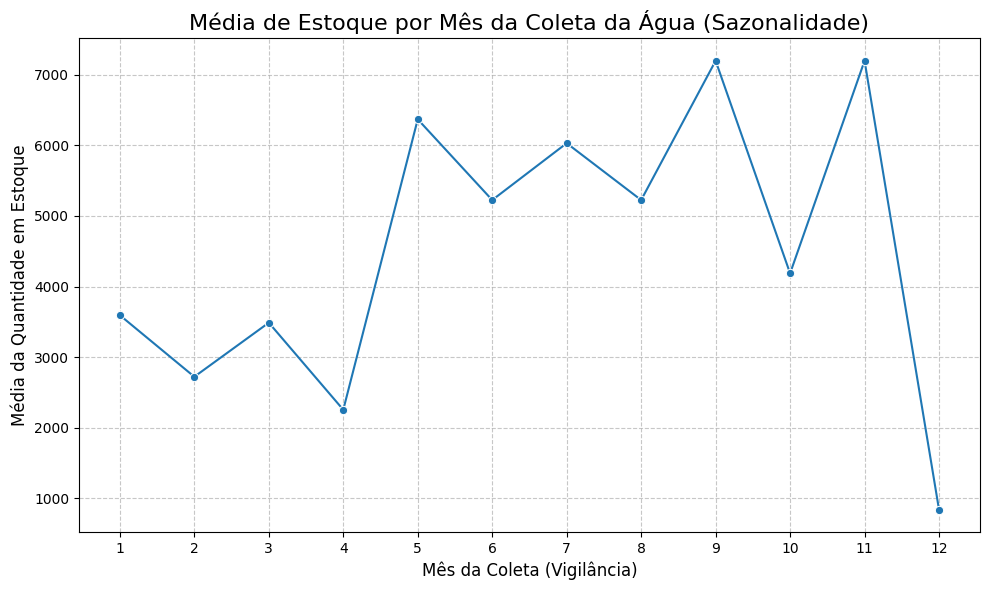


--- Média de Estoque por Mês de Posição de Estoque (Sazonalidade - Estoque) ---
ano_mes_dt
2024-05-01     527.519615
2024-06-01     564.996337
2024-07-01     632.647022
2024-08-01    6176.574519
2024-09-01     763.087009
2024-10-01     847.873977
2024-11-01    4282.043140
2024-12-01    4280.827815
2025-01-01    1835.632245
2025-02-01    3588.945096
2025-03-01    4744.041214
2025-04-01    5322.299789
2025-05-01    5828.080572
Name: qt_estoque, dtype: float64


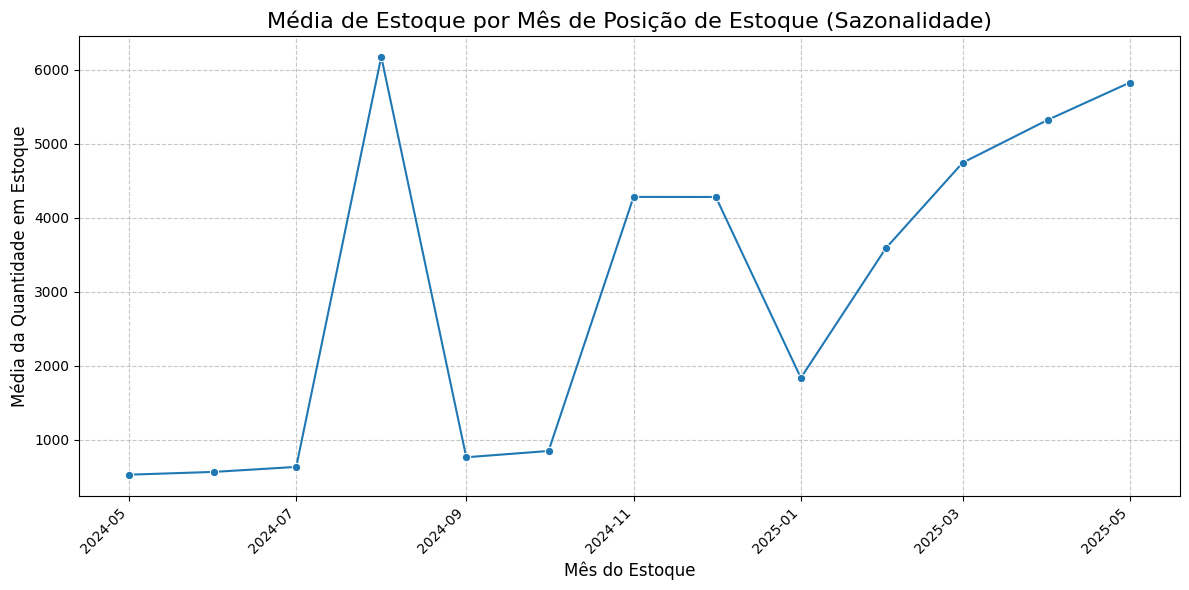

In [11]:
# --- 4.5. Distribuições para Sazonalidade ---
# Analisa a média de estoque por mês da coleta da água e por mês de posição de estoque.
limiar_alto_estoque = df_analise['qt_estoque'].quantile(0.75)
print(f"Limiar para 'alto estoque' (percentil 75): {limiar_alto_estoque:,.2f} unidades")

df_alto_estoque = df_analise[df_analise['qt_estoque'] > limiar_alto_estoque].copy()
frequencia_alto_estoque_por_categoria = df_alto_estoque['Categoria_Medicamento'].value_counts()
print("\n--- Frequência de registros com 'alto estoque' por Categoria de Medicamento ---")
print(frequencia_alto_estoque_por_categoria)

plt.figure(figsize=(8, 6))
sns.barplot(x=frequencia_alto_estoque_por_categoria.index, y=frequencia_alto_estoque_por_categoria.values, palette='viridis')
plt.title(f'Frequência de Registros com Estoque Acima de {limiar_alto_estoque:,.0f} Unidades por Categoria de Medicamento', fontsize=14)
plt.xlabel('Categoria de Medicamento', fontsize=12)
plt.ylabel('Número de Registros', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

estoque_medio_por_mes_vigilancia = df_analise.groupby('Mês')['qt_estoque'].mean()
print("\n--- Média de Estoque por Mês da Coleta da Água (Sazonalidade - Vigilância) ---")
print(estoque_medio_por_mes_vigilancia)

plt.figure(figsize=(10, 6))
sns.lineplot(x=estoque_medio_por_mes_vigilancia.index, y=estoque_medio_por_mes_vigilancia.values, marker='o')
plt.title('Média de Estoque por Mês da Coleta da Água (Sazonalidade)', fontsize=16)
plt.xlabel('Mês da Coleta (Vigilância)', fontsize=12)
plt.ylabel('Média da Quantidade em Estoque', fontsize=12)
plt.xticks(range(1, 13), fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

df_analise['ano_mes_dt'] = pd.to_datetime(df_analise['ano_mes'], format='%Y-%m')
estoque_medio_por_ano_mes_estoque = df_analise.groupby('ano_mes_dt')['qt_estoque'].mean().sort_index()

print("\n--- Média de Estoque por Mês de Posição de Estoque (Sazonalidade - Estoque) ---")
print(estoque_medio_por_ano_mes_estoque)

plt.figure(figsize=(12, 6))
sns.lineplot(x=estoque_medio_por_ano_mes_estoque.index, y=estoque_medio_por_ano_mes_estoque.values, marker='o')
plt.title('Média de Estoque por Mês de Posição de Estoque (Sazonalidade)', fontsize=16)
plt.xlabel('Mês do Estoque', fontsize=12)
plt.ylabel('Média da Quantidade em Estoque', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Análise de Correlação


Iniciando análises de Correlação...

--- Correlação de Pearson entre qt_estoque e RESULTADO por Parâmetro ---


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning:

invalid value encountered in divide



  Parâmetro 'Turbidez (uT)': Correlação de Pearson = 0.0028
  Parâmetro 'Cloro residual livre (mg/L)': Correlação de Pearson = 0.0125
  Parâmetro 'pH': Correlação de Pearson = -0.0179
  Parâmetro 'Fluoreto (mg/L)': Correlação de Pearson = -0.0092

--- Visualização da Correlação (Scatter Plot para os principais) ---


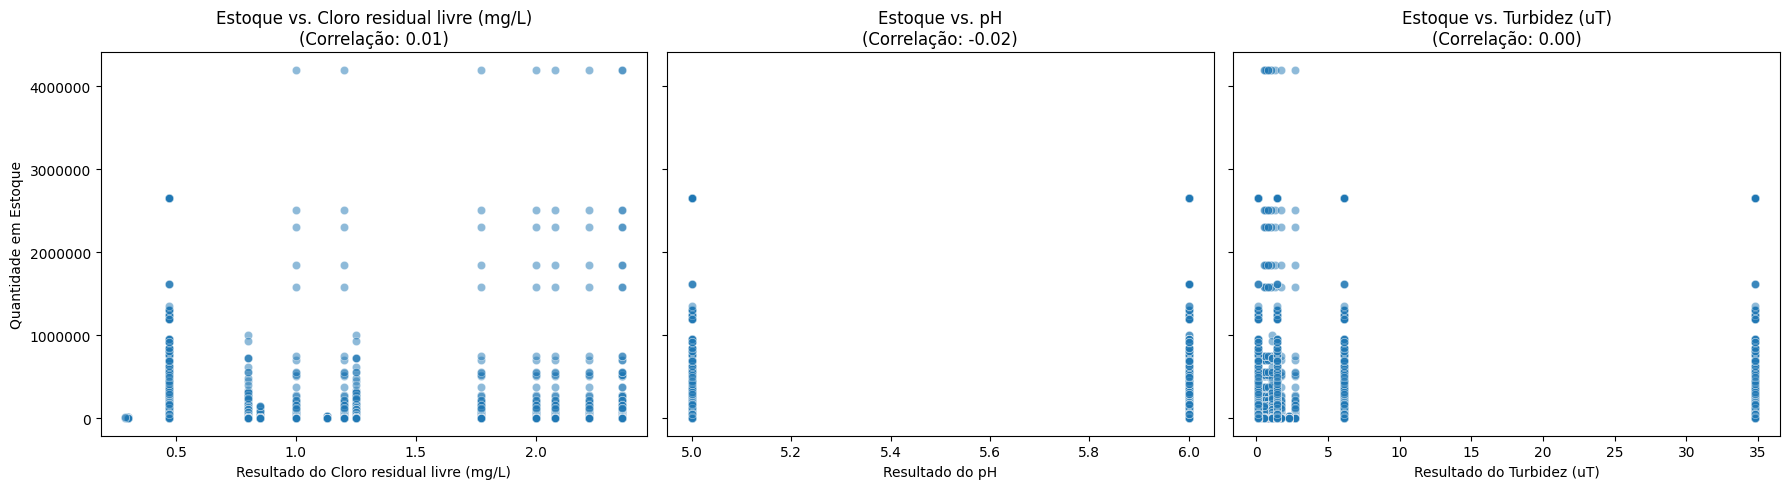

In [13]:
# ------------------------------------------------------------------------------
# 5. Análise de Correlação
# ------------------------------------------------------------------------------
# Esta seção investiga a força e a direção das relações entre variáveis
# quantitativas e a associação entre variáveis categóricas.

print("\nIniciando análises de Correlação...")
# --- 5.1. Correlação de Pearson (qt_estoque vs. RESULTADO por Parâmetro) ---
# Avalia a relação linear entre a quantidade em estoque e os valores dos parâmetros da água.
print("\n--- Correlação de Pearson entre qt_estoque e RESULTADO por Parâmetro ---")

df_correlacao = df_analise.dropna(subset=['qt_estoque', 'RESULTADO']).copy()
correlacoes_por_parametro = {}
for parametro in df_correlacao['Parâmetro'].unique():
    subset = df_correlacao[df_correlacao['Parâmetro'] == parametro]
    if len(subset) > 1:
        corr = subset['qt_estoque'].corr(subset['RESULTADO'])
        if pd.notna(corr):
            correlacoes_por_parametro[parametro] = corr

for param, corr_value in correlacoes_por_parametro.items():
    print(f"  Parâmetro '{param}': Correlação de Pearson = {corr_value:.4f}")

print("\n--- Visualização da Correlação (Scatter Plot para os principais) ---")
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
axes = axes.flatten()
relevant_params = ['Cloro residual livre (mg/L)', 'pH', 'Turbidez (uT)']

for i, param in enumerate(relevant_params):
    subset = df_correlacao[df_correlacao['Parâmetro'] == param]
    if not subset.empty:
        sns.scatterplot(x='RESULTADO', y='qt_estoque', data=subset, ax=axes[i], alpha=0.5)
        axes[i].set_title(f'Estoque vs. {param}\n(Correlação: {correlacoes_por_parametro.get(param, "N/A"):.2f})', fontsize=12)
        axes[i].set_xlabel(f'Resultado do {param}', fontsize=10)
        axes[i].set_ylabel('Quantidade em Estoque', fontsize=10)
        axes[i].ticklabel_format(style='plain', axis='y')
    else:
        axes[i].set_title(f'{param} - Sem dados para plotar', fontsize=12)
        axes[i].set_xlabel(f'Resultado do {param}', fontsize=10)
        axes[i].set_ylabel('Quantidade em Estoque', fontsize=10)

plt.tight_layout()
plt.show()


In [14]:
# --- 5.2. Teste Qui-quadrado (Associação entre Variáveis Categóricas) ---
# Avalia a associação entre tipo de produto/programa de saúde e parâmetros da água.
print("\n--- Teste Qui-quadrado para tp_produto x Parâmetro ---")
contingency_table_tp_param = pd.crosstab(df_analise['tp_produto'], df_analise['Parâmetro'])
print("Tabela de Contingência (tp_produto x Parâmetro):")
print(contingency_table_tp_param)
chi2, p_val, dof, ex = chi2_contingency(contingency_table_tp_param)
print(f"\nTeste Qui-quadrado para tp_produto x Parâmetro:")
print(f"  Estatística Qui-quadrado: {chi2:.4f}")
print(f"  P-valor: {p_val:.4f}")
print(f"  Graus de Liberdade: {dof}")
if p_val < 0.05:
    print("  Conclusão: Há uma associação significativa entre o tipo de produto e o parâmetro da água (rejeita H0 de independência).")
else:
    print("  Conclusão: Não há evidência de associação significativa entre o tipo de produto e o parâmetro da água (não rejeita H0 de independência).")

print("\n--- Teste Qui-quadrado para sg_programa_saude x Parâmetro ---")
contingency_table_prog_param = pd.crosstab(df_analise['sg_programa_saude'], df_analise['Parâmetro'])
print("Tabela de Contingência (sg_programa_saude x Parâmetro):")
print(contingency_table_prog_param)
chi2, p_val, dof, ex = chi2_contingency(contingency_table_prog_param)
print(f"\nTeste Qui-quadrado para sg_programa_saude x Parâmetro:")
print(f"  Estatística Qui-quadrado: {chi2:.4f}")
print(f"  P-valor: {p_val:.4f}")
print(f"  Graus de Liberdade: {dof}")
if p_val < 0.05:
    print("  Conclusão: Há uma associação significativa entre o programa de saúde e o parâmetro da água (rejeita H0 de independência).")
else:
    print("  Conclusão: Não há evidência de associação significativa entre o programa de saúde e o parâmetro da água (não rejeita H0 de independência).")


--- Teste Qui-quadrado para tp_produto x Parâmetro ---
Tabela de Contingência (tp_produto x Parâmetro):
Parâmetro   Cloro residual livre (mg/L)  Cor Aparente (uH)  Fluoreto (mg/L)  \
tp_produto                                                                    
B                                124673              52463            15719   
E                                  3914               7813             2390   
O                                 89366               4583             1299   
S                                  5276               1776              496   

Parâmetro   Turbidez (uT)      pH  
tp_produto                         
B                  162509  141146  
E                    5996       0  
O                  144737  143162  
S                    6052    5776  

Teste Qui-quadrado para tp_produto x Parâmetro:
  Estatística Qui-quadrado: 86027.0356
  P-valor: 0.0000
  Graus de Liberdade: 12
  Conclusão: Há uma associação significativa entre o tipo de produto e o 

**Probabilidade**

In [15]:
# ------------------------------------------------------------------------------
# 6. Probabilidade
# ------------------------------------------------------------------------------
# Esta seção calcula probabilidades de eventos simples e condicionais,
# e constrói tabelas de contingência para entender a chance de eventos
# de estoque ocorrerem em relação à qualidade da água.

print("\nIniciando análises de Probabilidade...")

# --- 6.1. Cálculo de Eventos Simples ---
# Probabilidade de um município ter estoque de "Albendazol"
municipios_com_albendazol = df_analise[df_analise['ds_produto'].str.contains('ALBENDAZOL', case=False, na=False)]['co_municipio_ibge'].nunique()
total_municipios = df_analise['co_municipio_ibge'].nunique()
prob_albendazol = municipios_com_albendazol / total_municipios
print(f"\n--- Probabilidade de um município ter estoque de 'Albendazol' ---")
print(f"Número de municípios com estoque de Albendazol: {municipios_com_albendazol}")
print(f"Total de municípios únicos na análise: {total_municipios}")
print(f"P(Albendazol) = {prob_albendazol:.4f} ou {prob_albendazol:.2%}")

# Probabilidade de um município apresentar "Cloro Residual Livre" fora da faixa ideal
df_cloro = df_analise[df_analise['Parâmetro'] == 'Cloro residual livre (mg/L)']
municipios_cloro_inadequado = df_cloro[df_cloro['qualidade_agua_simples'] == 'Inadequada']['co_municipio_ibge'].nunique()
total_municipios_com_cloro = df_cloro['co_municipio_ibge'].nunique()
if total_municipios_com_cloro > 0:
    prob_cloro_fora_ideal = municipios_cloro_inadequado / total_municipios_com_cloro
else:
    prob_cloro_fora_ideal = 0
print(f"\n--- Probabilidade de um município apresentar 'Cloro Residual Livre' fora da faixa ideal ---")
print(f"Número de municípios com Cloro Inadequado: {municipios_cloro_inadequado}")
print(f"Total de municípios únicos com dados de Cloro: {total_municipios_com_cloro}")
print(f"P(Cloro fora do ideal) = {prob_cloro_fora_ideal:.4f} ou {prob_cloro_fora_ideal:.2%}")

# --- 6.2. Cálculo de Eventos Condicionais ---
# Probabilidade de haver estoque de antibióticos condicional à qualidade da água.
total_municipios_inadequada = df_analise[df_analise['qualidade_agua_simples'] == 'Inadequada']['co_municipio_ibge'].nunique()
municipios_inadequada_com_antibiotico = df_analise[
    (df_analise['qualidade_agua_simples'] == 'Inadequada') & (df_analise['is_antibiotico'] == True)
]['co_municipio_ibge'].nunique()
if total_municipios_inadequada > 0:
    prob_antibiotico_dada_agua_ruim = municipios_inadequada_com_antibiotico / total_municipios_inadequada
else:
    prob_antibiotico_dada_agua_ruim = 0
print(f"\n--- Probabilidade de Antibiótico | Água Inadequada ---")
print(f"Total de municípios com água Inadequada: {total_municipios_inadequada}")
print(f"Municípios com água Inadequada E estoque de antibióticos: {municipios_inadequada_com_antibiotico}")
print(f"P(Antibiótico | Água Inadequada) = {prob_antibiotico_dada_agua_ruim:.4f} ou {prob_antibiotico_dada_agua_ruim:.2%}")

total_municipios_adequada = df_analise[df_analise['qualidade_agua_simples'] == 'Adequada']['co_municipio_ibge'].nunique()
municipios_adequada_com_antibiotico = df_analise[
    (df_analise['qualidade_agua_simples'] == 'Adequada') & (df_analise['is_antibiotico'] == True)
]['co_municipio_ibge'].nunique()
if total_municipios_adequada > 0:
    prob_antibiotico_dada_agua_boa = municipios_adequada_com_antibiotico / total_municipios_adequada
else:
    prob_antibiotico_dada_agua_boa = 0
print(f"\n--- Probabilidade de Antibiótico | Água Adequada ---")
print(f"Total de municípios com água Adequada: {total_municipios_adequada}")
print(f"Municípios com água Adequada E estoque de antibióticos: {municipios_adequada_com_antibiotico}")
print(f"P(Antibiótico | Água Adequada) = {prob_antibiotico_dada_agua_boa:.4f} ou {prob_antibiotico_dada_agua_boa:.2%}")



Iniciando análises de Probabilidade...

--- Probabilidade de um município ter estoque de 'Albendazol' ---
Número de municípios com estoque de Albendazol: 5
Total de municípios únicos na análise: 7
P(Albendazol) = 0.7143 ou 71.43%

--- Probabilidade de um município apresentar 'Cloro Residual Livre' fora da faixa ideal ---
Número de municípios com Cloro Inadequado: 0
Total de municípios únicos com dados de Cloro: 7
P(Cloro fora do ideal) = 0.0000 ou 0.00%

--- Probabilidade de Antibiótico | Água Inadequada ---
Total de municípios com água Inadequada: 1
Municípios com água Inadequada E estoque de antibióticos: 1
P(Antibiótico | Água Inadequada) = 1.0000 ou 100.00%

--- Probabilidade de Antibiótico | Água Adequada ---
Total de municípios com água Adequada: 7
Municípios com água Adequada E estoque de antibióticos: 6
P(Antibiótico | Água Adequada) = 0.8571 ou 85.71%


**Tabelas de Contigência**

In [16]:
# --- 6.3. Tabelas de Contingência ---
# Constrói uma tabela de contingência para analisar a associação entre presença de antibióticos e qualidade da água.
municipios_com_antibiotico_flag = df_analise.groupby('co_municipio_ibge')['is_antibiotico'].any().reset_index()
municipios_com_antibiotico_flag.rename(columns={'is_antibiotico': 'tem_antibiotico_no_municipio'}, inplace=True)

qualidade_predominante_municipio = df_analise.groupby('co_municipio_ibge')['qualidade_agua_simples'].apply(
    lambda x: x.mode()[0] if not x.mode().empty else 'Não Definido'
).reset_index()
qualidade_predominante_municipio.rename(columns={'qualidade_agua_simples': 'qualidade_agua_dominante'}, inplace=True)

df_municipio_prob = pd.merge(municipios_com_antibiotico_flag, qualidade_predominante_municipio, on='co_municipio_ibge', how='inner')
df_tabela_contingencia = df_municipio_prob[
    df_municipio_prob['qualidade_agua_dominante'].isin(['Adequada', 'Inadequada'])
].copy()

print("\n--- Tabela de Contingência Bruta (Antibiótico vs. Qualidade da Água) ---")
print(df_tabela_contingencia['tem_antibiotico_no_municipio'].unique())
print(df_tabela_contingencia['qualidade_agua_dominante'].unique())

contingency_table = pd.crosstab(
    df_tabela_contingencia['tem_antibiotico_no_municipio'],
    df_tabela_contingencia['qualidade_agua_dominante']
)
print("\n--- Tabela de Contingência Bruta ---")
print(contingency_table)

index_mapping = {False: 'Não Tem Antibiótico', True: 'Tem Antibiótico'}
column_mapping = {'Adequada': 'Água Adequada', 'Inadequada': 'Água Inadequada'}

contingency_table.rename(index={idx: index_mapping[idx] for idx in contingency_table.index if idx in index_mapping},
                         columns={col: column_mapping[col] for col in contingency_table.columns if col in column_mapping},
                         inplace=True)

print("\n--- Tabela de Contingência: Presença de Antibiótico por Qualidade da Água (Nível Município) ---")
print(contingency_table)

contingency_table_with_totals = contingency_table.copy()
contingency_table_with_totals['Total'] = contingency_table_with_totals.sum(axis=1)
contingency_table_with_totals.loc['Total'] = contingency_table_with_totals.sum(axis=0)
print("\nTabela de Contingência com Totais:")
print(contingency_table_with_totals)



--- Tabela de Contingência Bruta (Antibiótico vs. Qualidade da Água) ---
[ True]
['Adequada']

--- Tabela de Contingência Bruta ---
qualidade_agua_dominante      Adequada
tem_antibiotico_no_municipio          
True                                 5

--- Tabela de Contingência: Presença de Antibiótico por Qualidade da Água (Nível Município) ---
qualidade_agua_dominante      Água Adequada
tem_antibiotico_no_municipio               
Tem Antibiótico                           5

Tabela de Contingência com Totais:
qualidade_agua_dominante      Água Adequada  Total
tem_antibiotico_no_municipio                      
Tem Antibiótico                           5      5
Total                                     5      5


**Inferência**

In [17]:
# ------------------------------------------------------------------------------
# 7. Inferência Estatística
# ------------------------------------------------------------------------------
# Esta seção utiliza dados amostrais para realizar generalizações e estimativas
# sobre a população, incluindo testes de hipóteses e intervalos de confiança.
# Observações importantes sobre as limitações da amostra para validade inferencial.

print("\nIniciando análises de Inferência Estatística...")

# --- 7.1. Testes de Hipóteses ---

# Teste Z para uma Proporção Única (Municípios com Albendazol)
num_sucessos_albendazol = df_analise[df_analise['ds_produto'].str.contains('ALBENDAZOL', case=False, na=False)]['co_municipio_ibge'].nunique()
num_observacoes_albendazol = df_analise['co_municipio_ibge'].nunique()
proporcao_hipotetica = 0.50

print("\n--- Teste Z para uma Proporção Única (Municípios com Albendazol) ---")
stat_prop_unica, pval_prop_unica = proportions_ztest(count=num_sucessos_albendazol, nobs=num_observacoes_albendazol, value=proporcao_hipotetica, alternative='two-sided')

print(f"Proporção observada de municípios com Albendazol: {num_sucessos_albendazol / num_observacoes_albendazol:.2%}")
print(f"Proporção hipotética (H0): {proporcao_hipotetica:.2%}")
print(f"Estatística Z: {stat_prop_unica:.4f}")
print(f"P-valor: {pval_prop_unica:.4f}")
if pval_prop_unica < 0.05:
    print(f"Conclusão: Rejeita-se H0. Há evidência estatística de que a proporção de municípios com Albendazol é significativamente diferente de {proporcao_hipotetica:.2%}.")
else:
    print(f"Conclusão: Não se rejeita H0. Não há evidência estatística de que a proporção de municípios com Albendazol é significativamente diferente de {proporcao_hipotetica:.2%}.")


# Teste de Kruskal-Wallis (Medianas de Estoque vs. Qualidade da Água)
print("\n--- Teste de Kruskal-Wallis (Medianas de Estoque vs. Qualidade da Água) ---")
grupos_estoque_qualidade = []
qualidades = df_analise['qualidade_agua_simples'].unique()
for q in qualidades:
    subset = df_analise[df_analise['qualidade_agua_simples'] == q]['qt_estoque'].dropna()
    if len(subset) > 0:
        grupos_estoque_qualidade.append(subset)
        print(f"  Tamanho do grupo '{q}': {len(subset)}")

if len(grupos_estoque_qualidade) < 2:
    print("\nAVISO: Menos de 2 grupos com dados para realizar o Teste de Kruskal-Wallis. Não é possível comparar.")
else:
    stat_kruskal, pval_kruskal = kruskal(*grupos_estoque_qualidade)
    print(f"\nResultado do Teste de Kruskal-Wallis:")
    print(f"  Estatística H: {stat_kruskal:.4f}")
    print(f"  P-valor: {pval_kruskal:.4f}")
    if pval_kruskal < 0.05:
        print("  Conclusão: Rejeita-se H0. Há uma diferença estatisticamente significativa nas medianas de estoque entre pelo menos dois grupos de qualidade da água.")
    else:
        print("  Conclusão: Não se rejeita H0. Não há evidência estatística de diferença nas medianas de estoque entre os grupos de qualidade da água.")




Iniciando análises de Inferência Estatística...

--- Teste Z para uma Proporção Única (Municípios com Albendazol) ---
Proporção observada de municípios com Albendazol: 71.43%
Proporção hipotética (H0): 50.00%
Estatística Z: 1.2550
P-valor: 0.2095
Conclusão: Não se rejeita H0. Não há evidência estatística de que a proporção de municípios com Albendazol é significativamente diferente de 50.00%.

--- Teste de Kruskal-Wallis (Medianas de Estoque vs. Qualidade da Água) ---
  Tamanho do grupo 'Adequada': 682163
  Tamanho do grupo 'Inadequada': 150444
  Tamanho do grupo 'Não Classificado': 86539

Resultado do Teste de Kruskal-Wallis:
  Estatística H: 4638.5545
  P-valor: 0.0000
  Conclusão: Rejeita-se H0. Há uma diferença estatisticamente significativa nas medianas de estoque entre pelo menos dois grupos de qualidade da água.


**Intervalos**

In [23]:
import scipy.stats as stats

In [18]:
# --- 7.2. Intervalos de Confiança ---

# Intervalo para a proporção de municípios com medicamentos antiparasitários (Albendazol)
print("\n--- Intervalo de Confiança para a Proporção de Municípios com Antiparasitários (Albendazol) ---")
num_sucessos_albendazol_ic = df_analise[df_analise['ds_produto'].str.contains('ALBENDAZOL', case=False, na=False)]['co_municipio_ibge'].nunique()
num_observacoes_albendazol_ic = df_analise['co_municipio_ibge'].nunique()

print(f"Número de municípios com Albendazol: {num_sucessos_albendazol_ic}")
print(f"Total de municípios na amostra: {num_observacoes_albendazol_ic}")

if num_observacoes_albendazol_ic == 0:
    print("AVISO: Amostra vazia, não é possível calcular o intervalo de confiança.")
else:
    ic_low, ic_high = proportion_confint(count=num_sucessos_albendazol_ic, nobs=num_observacoes_albendazol_ic, alpha=0.05, method='wilson')
    print(f"\nIntervalo de Confiança (95%) para a proporção de municípios com Albendazol:")
    print(f"  IC = ({ic_low:.4f}; {ic_high:.4f}) ou ({ic_low:.2%}; {ic_high:.2%})")
    print("  Com 95% de confiança, a verdadeira proporção de municípios que possuem Albendazol na população está dentro deste intervalo.")



--- Intervalo de Confiança para a Proporção de Municípios com Antiparasitários (Albendazol) ---
Número de municípios com Albendazol: 5
Total de municípios na amostra: 7

Intervalo de Confiança (95%) para a proporção de municípios com Albendazol:
  IC = (0.3589; 0.9178) ou (35.89%; 91.78%)
  Com 95% de confiança, a verdadeira proporção de municípios que possuem Albendazol na população está dentro deste intervalo.


In [24]:
# Intervalo para a proporção de municípios com medicamentos antiparasitários (Albendazol)
print("\n--- Intervalo de Confiança para a Proporção de Municípios com Antiparasitários (Albendazol) ---")
num_sucessos_albendazol_ic = df_analise[df_analise['ds_produto'].str.contains('ALBENDAZOL', case=False, na=False)]['co_municipio_ibge'].nunique()
num_observacoes_albendazol_ic = df_analise['co_municipio_ibge'].nunique()

print(f"Número de municípios com Albendazol: {num_sucessos_albendazol_ic}")
print(f"Total de municípios na amostra: {num_observacoes_albendazol_ic}")

if num_observacoes_albendazol_ic == 0:
    print("AVISO: Amostra vazia, não é possível calcular o intervalo de confiança.")
else:
    ic_low, ic_high = proportion_confint(count=num_sucessos_albendazol_ic, nobs=num_observacoes_albendazol_ic, alpha=0.05, method='wilson')
    print(f"\nIntervalo de Confiança (95%) para a proporção de municípios com Albendazol:")
    print(f"  IC = ({ic_low:.4f}; {ic_high:.4f}) ou ({ic_low:.2%}; {ic_high:.2%})")
    print("  Com 95% de confiança, a verdadeira proporção de municípios que possuem Albendazol na população está dentro deste intervalo.")


# Intervalo de confiança para média de estoque total de medicamentos
print("\n--- Intervalo de Confiança para a Média de Estoque Total de Medicamentos ---")
data_qt_estoque = df_analise['qt_estoque'].dropna()
if len(data_qt_estoque) == 0:
    print("AVISO: Dados de estoque vazios, não é possível calcular o intervalo de confiança.")
else:
    media_estoque = data_qt_estoque.mean()
    std_estoque = data_qt_estoque.std()
    n_estoque = len(data_qt_estoque)
    ic_low_mean, ic_high_mean = stats.t.interval(confidence=0.95, df=n_estoque-1, loc=media_estoque, scale=std_estoque / np.sqrt(n_estoque))
    print(f"Média de Estoque na amostra: {media_estoque:,.2f}")
    print(f"Desvio Padrão do Estoque na amostra: {std_estoque:,.2f}")
    print(f"Tamanho da amostra (registros de estoque): {n_estoque}")
    print(f"\nIntervalo de Confiança (95%) para a média de estoque total:")
    print(f"  IC = ({ic_low_mean:,.2f}; {ic_high_mean:,.2f}) unidades")
    print("  Com 95% de confiança, a verdadeira média de estoque de medicamentos na população está dentro deste intervalo.")



--- Intervalo de Confiança para a Proporção de Municípios com Antiparasitários (Albendazol) ---
Número de municípios com Albendazol: 5
Total de municípios na amostra: 7

Intervalo de Confiança (95%) para a proporção de municípios com Albendazol:
  IC = (0.3589; 0.9178) ou (35.89%; 91.78%)
  Com 95% de confiança, a verdadeira proporção de municípios que possuem Albendazol na população está dentro deste intervalo.

--- Intervalo de Confiança para a Média de Estoque Total de Medicamentos ---
Média de Estoque na amostra: 3,399.82
Desvio Padrão do Estoque na amostra: 54,784.26
Tamanho da amostra (registros de estoque): 919146

Intervalo de Confiança (95%) para a média de estoque total:
  IC = (3,287.82; 3,511.82) unidades
  Com 95% de confiança, a verdadeira média de estoque de medicamentos na população está dentro deste intervalo.
